In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nba_creation_date import CreationDate, date_string_to_datetime

In [3]:
df = pd.read_excel('data/training_set.xlsx')
df.rename(columns={'Followers at Posting': 'Followers'}, inplace=True)
df.head()

,Engagements,Followers,Created,Type,Description
0,502093,36984682,2019-05-21 23:30:51 EDT,Video,The @raptors bench trio of @sergeibaka @norman...
1,603380,36984682,2019-05-21 22:53:33 EDT,Video,@kyle_lowry7 pulls from deep for the @raptors ...
2,603380,36984682,2019-05-21 22:19:58 EDT,Video,@k_mid22 with some english on the @bucks dime!
3,725100,36984682,2019-05-21 22:02:41 EDT,Video,Kawhi punches it home with the left on TNT!
4,661446,36984682,2019-05-21 20:47:49 EDT,Video,@giannis_an34 goes baseline early to rock the ...


In [5]:
# Adding extra date-related columns
cds = [CreationDate(date_string_to_datetime(c)) for c in df['Created']]
df['datetime'] = [c.dt for c in cds]
df['year'] = [c.get_year() for c in cds]
df['month'] = [c.get_month() for c in cds]
df['month_int'] = [c.get_month_int() for c in cds]
df['weekday'] = [c.get_weekday() for c in cds]
df['day_time'] = [c.get_day_section() for c in cds]
df['is_playoffs'] = [c.is_playoffs() for c in cds]

In [6]:
df.head()

,Engagements,Followers,Created,Type,Description,datetime,year,month,month_int,weekday,day_time,is_playoffs
0,502093,36984682,2019-05-21 23:30:51 EDT,Video,The @raptors bench trio of @sergeibaka @norman...,2019-05-21 23:30:51,2019,May,5,Tuesday,postgame,True
1,603380,36984682,2019-05-21 22:53:33 EDT,Video,@kyle_lowry7 pulls from deep for the @raptors ...,2019-05-21 22:53:33,2019,May,5,Tuesday,night,True
2,603380,36984682,2019-05-21 22:19:58 EDT,Video,@k_mid22 with some english on the @bucks dime!,2019-05-21 22:19:58,2019,May,5,Tuesday,night,True
3,725100,36984682,2019-05-21 22:02:41 EDT,Video,Kawhi punches it home with the left on TNT!,2019-05-21 22:02:41,2019,May,5,Tuesday,night,True
4,661446,36984682,2019-05-21 20:47:49 EDT,Video,@giannis_an34 goes baseline early to rock the ...,2019-05-21 20:47:49,2019,May,5,Tuesday,evening,True


In [111]:
df.to_csv('training_set_extended.csv')

## Variable exploration: Engagements

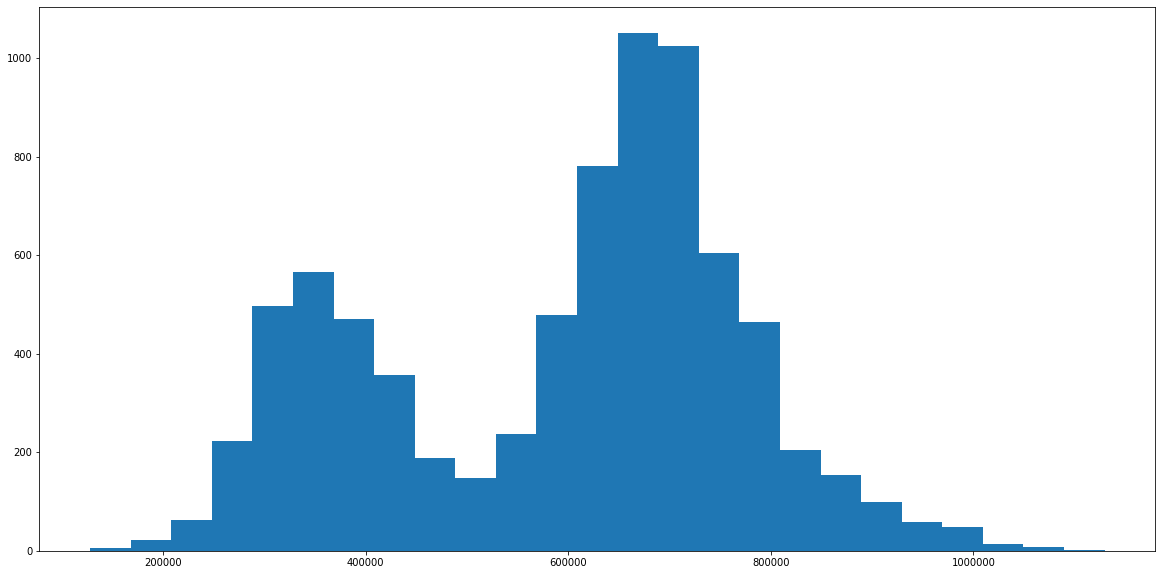

In [7]:
plt.figure(figsize=(20,10))
plt.hist(df['Engagements'], bins=25)
plt.show()

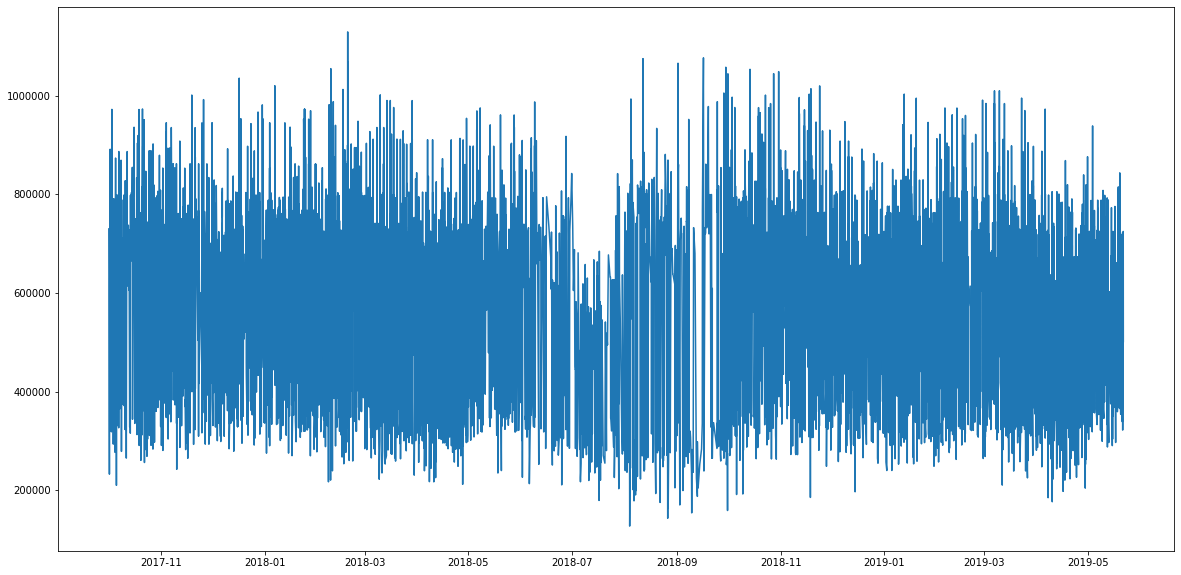

In [46]:
plt.figure(figsize=(20,10))
plt.plot(df['datetime'], df['Engagements'])
plt.show()

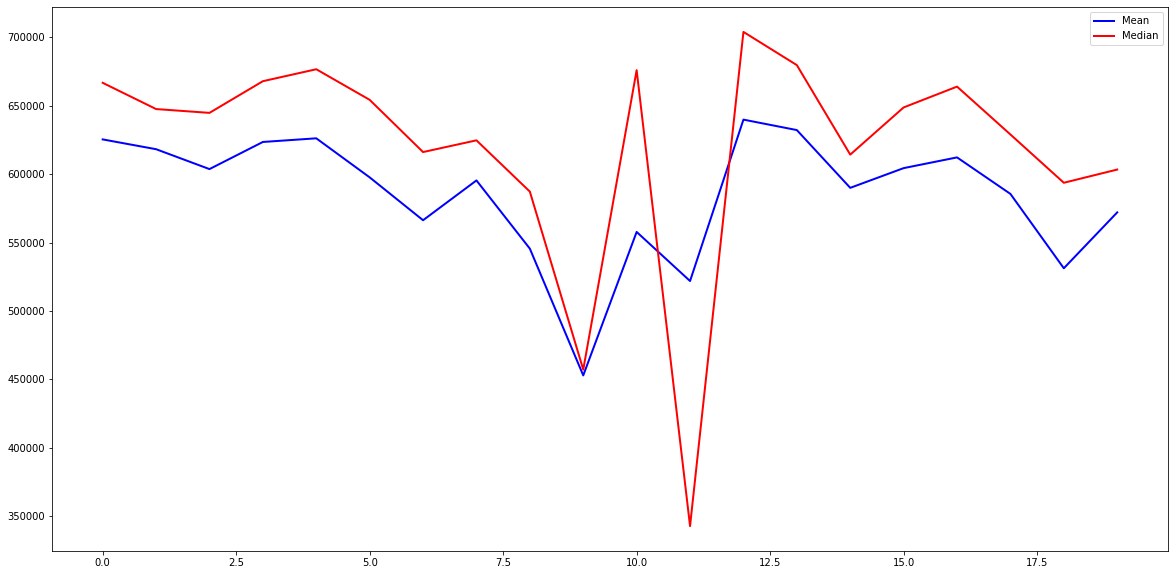

In [52]:
df_mean = df.groupby(['year','month_int']).mean()[['Engagements']].reset_index()
df_median = df.groupby(['year','month_int']).median()[['Engagements']].reset_index()
plt.figure(figsize=(20,10))
plt.plot(df_mean['Engagements'], color='b', lw=2, label='Mean')
plt.plot(df_median['Engagements'], color='r', lw=2, label='Median')
plt.legend()
plt.show()

## Variable exploration: Followers

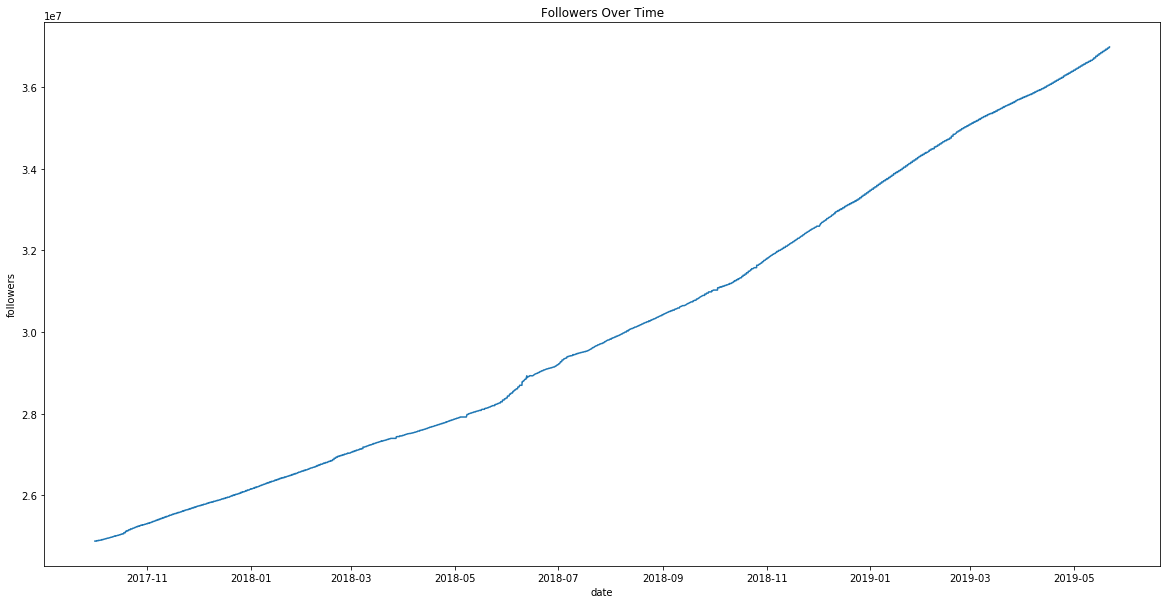

In [56]:
plt.figure(figsize=(20,10))
plt.plot(df['datetime'], df['Followers'])
plt.title('Followers Over Time')
plt.xlabel('date')
plt.ylabel('followers')
plt.show()

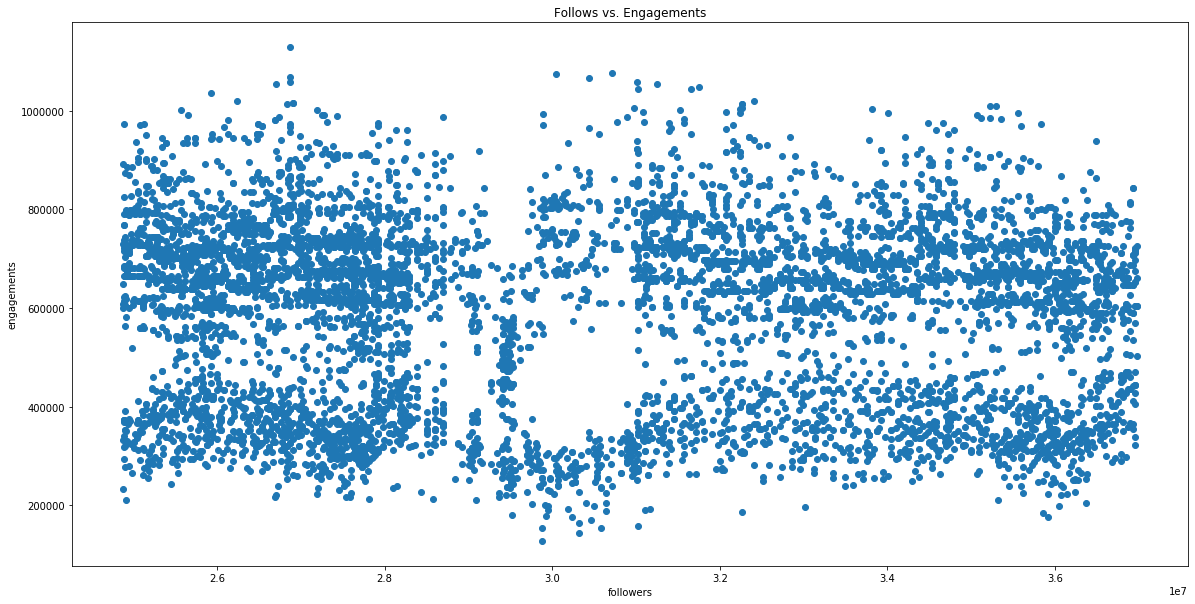

In [57]:
plt.figure(figsize=(20,10))
plt.scatter(df['Followers'], df['Engagements'])
plt.title('Follows vs. Engagements')
plt.xlabel('followers')
plt.ylabel('engagements')
plt.show()

Takeaways: Thought there would be more of a correlation between followers and engagements. Guess the number of engagements on posts hasn't really increased even as @nba has grown from ~25M followers to ~36M. Also why is the follows vs. engagements graph striated?? Does this have to do with the fact that the training data is fake?

## Variable exploration: Type

In [59]:
df.groupby('Type').median()[['Engagements', 'Followers']].reset_index()

,Type,Engagements,Followers
0,Album,348534.0,31097770.0
1,Photo,352718.0,29506145.0
2,Video,684944.5,29895844.0


Takeaway: Videos get significantly more engagements (nearly double) than albums and photos (which get about the same). Album has the highest median followers which indiciates it is a type of media that @nba has started using more recently, as followers is generally a strictly increasing number.

In [61]:
# split up by media type
df_vid = df[df['Type'] == 'Video']
df_pic = df[df['Type'] == 'Photo']
df_alb = df[df['Type'] == 'Album']

In [62]:
# number of posts
print('Videos:', str(len(df_vid)))
print('Photos:', str(len(df_pic)))
print('Albums:', str(len(df_alb)))

Videos: 5458
Photos: 1595
Albums: 713


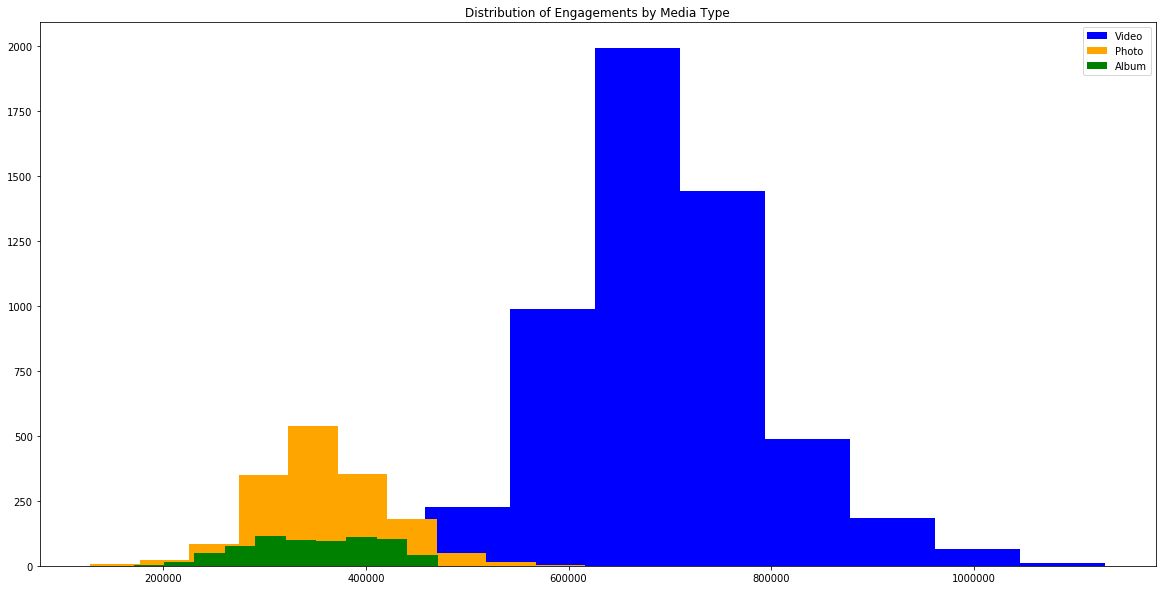

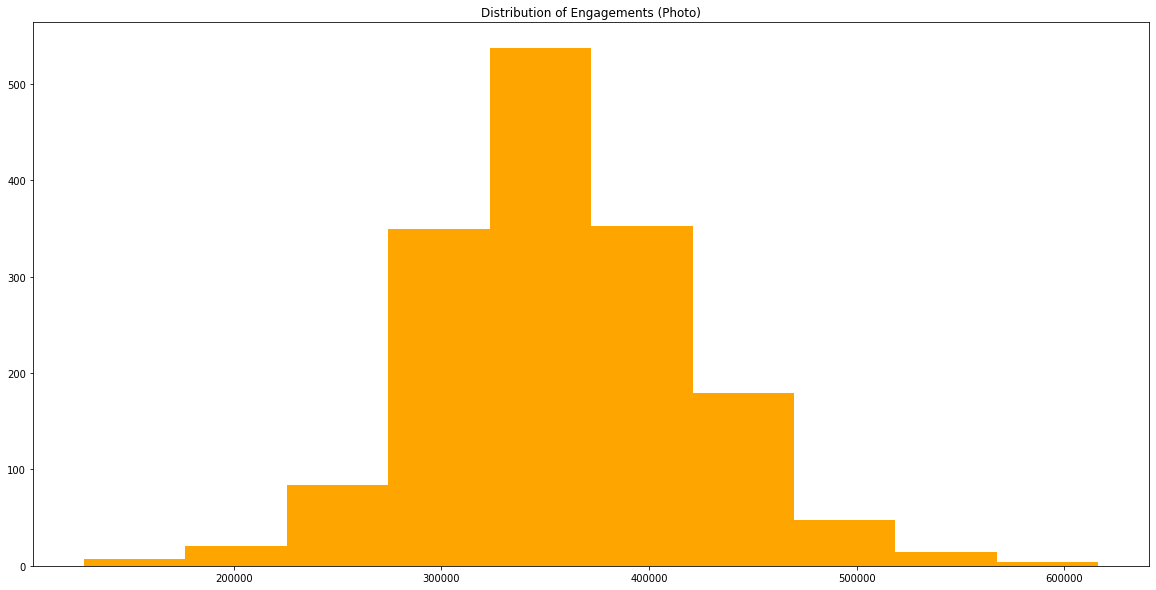

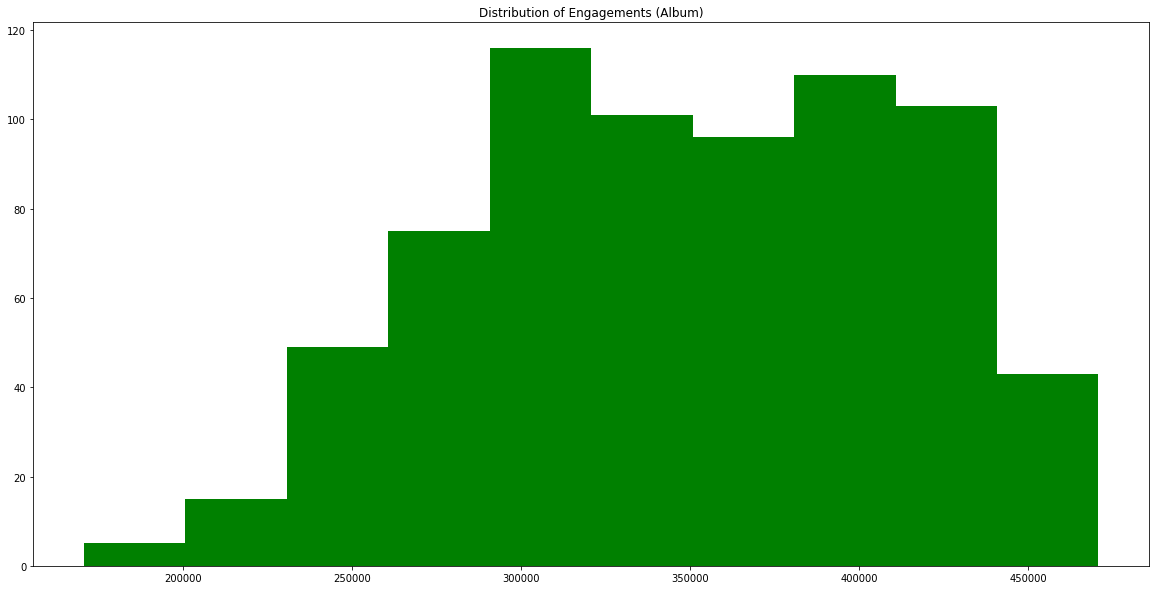

In [63]:
# distribution of engagement
plt.figure(figsize=(20,10))
plt.hist(df_vid['Engagements'], color='b', label='Video')
plt.hist(df_pic['Engagements'], color='orange', label='Photo')
plt.hist(df_alb['Engagements'], color='g', label='Album')
plt.title('Distribution of Engagements by Media Type')
plt.legend()
plt.show()

plt.figure(figsize=(20,10))
plt.hist(df_pic['Engagements'], color='orange')
plt.title('Distribution of Engagements (Photo)')
plt.show()

plt.figure(figsize=(20,10))
plt.hist(df_alb['Engagements'], color='g')
plt.title('Distribution of Engagements (Album)')
plt.show()

Takeaway: Different enough means and shapes of distributions that we probably want a different model for each media type. Limiting factor is having enough data to train the photo and especially album model. Worth trying both approaches.

Generally engagements are normally distributed but albums are more flat.

## Variable exploration: Created 

In [70]:
df_month = df.groupby('month_int').count()[['Engagements']].apply(lambda x:
                    round(x / float(x.sum()), 3)).reset_index()
df_month.rename(columns={'Engagements': 'prop. of posts'}, inplace=True)
df_month

,month_int,prop. of posts
0,1,0.121
1,2,0.120
2,3,0.113
3,4,0.125
4,5,0.093
5,6,0.030
6,7,0.030
7,8,0.024
8,9,0.021
9,10,0.101


In [77]:
print(df.groupby('is_playoffs').count()[['Engagements']]\
.reset_index().rename(columns={'Engagements': 'count'}))

print(df.groupby('day_time').count()[['Engagements']]\
.reset_index().rename(columns={'Engagements': 'count'}))

print(df.groupby('weekday').count()[['Engagements']]\
.reset_index().rename(columns={'Engagements': 'count'}))

   is_playoffs  count
0        False   6193
1         True   1573
    day_time  count
0  afternoon    907
1   deadzone    608
2    evening   2017
3      lunch    410
4    morning    434
5      night   2515
6   postgame    875
     weekday  count
0     Friday   1183
1     Monday    996
2   Saturday   1191
3     Sunday   1104
4   Thursday   1082
5    Tuesday   1044
6  Wednesday   1166


### Created x Type

In [91]:
df_month_type = df.groupby(['month_int','Type']).count()[['Engagements']]\
.reset_index().rename(columns={'Engagements': 'count'})
df_month_type.sort_values('month_int')

,month_int,Type,count
0,1,Album,101
1,1,Photo,142
2,1,Video,698
3,2,Album,96
4,2,Photo,199
5,2,Video,638
6,3,Album,89
7,3,Photo,165
8,3,Video,626
9,4,Album,60


## Basic model

In [107]:
import sklearn as sk
from sklearn import model_selection
from sklearn.linear_model import LinearRegression

In [108]:
# train/test split
df_video = df[df['Type'] == 'Video']
X = df_video[['Followers','year','month','weekday',
              'day_time','is_playoffs']]
y = df_video['Engagements']
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25, random_state=42)

In [109]:
lin_reg = LinearRegression().fit(X_train, y_train)

ValueError: could not convert string to float: 'October'

In [ ]:
X = np.array([[1, 1], [1, 2], [2, 2], [2, 3]])
>>> # y = 1 * x_0 + 2 * x_1 + 3
>>> y = np.dot(X, np.array([1, 2])) + 3
>>> reg = LinearRegression().fit(X, y)
>>> reg.score(X, y)
1.0
>>> reg.coef_
array([1., 2.])
>>> reg.intercept_ 
3.0000...
>>> reg.predict(np.array([[3, 5]]))
array([16.])